In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [5]:
next(iter(train_loader))[0].shape

torch.Size([256, 5, 14])

In [6]:
# Define the Attention Block as a separate module for clarity
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attn_dense = nn.Linear(feature_dim, feature_dim)

    def forward(self, x):
        attn_scores = self.attn_dense(x)
        attn_weights = F.softmax(attn_scores, dim=-1)
        output_attention_mul = x * attn_weights

        return output_attention_mul

# Define the main model
class CnnBiLSTMAttention(nn.Module):
    def __init__(self, input_dims, time_steps, lstm_units, dropout_rate=0.3):
        super(CnnBiLSTMAttention, self).__init__()

        self.conv1d = nn.Conv1d(in_channels=input_dims, out_channels=96, kernel_size=1)
        self.conv_dropout = nn.Dropout(dropout_rate)

        self.bilstm = nn.LSTM(
            input_size=96,
            hidden_size=lstm_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.lstm_dropout = nn.Dropout(dropout_rate)

        self.attention = Attention(feature_dim=lstm_units * 2)
        # self.attention =

        self.output_dense = nn.Linear(time_steps * lstm_units * 2, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = F.relu(x)
        x = x.permute(0, 2, 1)
        x = self.conv_dropout(x)

        lstm_out, _ = self.bilstm(x)
        lstm_out = self.lstm_dropout(lstm_out)

        attention_mul = self.attention(lstm_out)

        flattened = attention_mul.reshape(attention_mul.size(0), -1)

        output = self.output_dense(flattened)

        return output

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [8]:
model = CnnBiLSTMAttention(input_dims=len(features), time_steps=5, lstm_units=6)

In [9]:
# model(next(iter(train_loader))[0]).shape

In [10]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [11]:
# Training the model using the train_loader, val_loader, and test_loader
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

num_epochs = 300
best_val_loss = float('inf')
patience = 30
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/temp_models/cnn_bilstm_attention5.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        # Create a temporary model to load and evaluate the existing model
        temp_lstm = CnnBiLSTMAttention(input_dims=len(features), time_steps=5, lstm_units=2)
        temp_lstm.load_state_dict(torch.load(existing_model_path))
        temp_lstm.eval()

        # Evaluate existing model on validation set
        existing_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = temp_lstm(batch_x)
                loss = criterion(outputs, batch_y)
                existing_val_loss += loss.item()

        existing_best_val_loss = existing_val_loss / len(val_loader)
        print(f"Existing model validation loss: {existing_best_val_loss:.6f}")

        # Delete temporary model to free memory
        del temp_lstm
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

# After training is complete, compare with existing model and save only if better
if best_val_loss < existing_best_val_loss:
    torch.save(model.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with validation loss: {best_val_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model validation loss: {best_val_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest validation loss achieved this training: {best_val_loss:.6f}')

Could not load existing model: Error(s) in loading state_dict for CnnBiLSTMAttention:
	size mismatch for bilstm.weight_ih_l0: copying a param with shape torch.Size([24, 96]) from checkpoint, the shape in current model is torch.Size([8, 96]).
	size mismatch for bilstm.weight_hh_l0: copying a param with shape torch.Size([24, 6]) from checkpoint, the shape in current model is torch.Size([8, 2]).
	size mismatch for bilstm.bias_ih_l0: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for bilstm.bias_hh_l0: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for bilstm.weight_ih_l0_reverse: copying a param with shape torch.Size([24, 96]) from checkpoint, the shape in current model is torch.Size([8, 96]).
	size mismatch for bilstm.weight_hh_l0_reverse: copying a param with shape torch.Size([24, 6]) from checkpoint, the shape in current model is torch.

  0%|          | 0/10 [00:00<?, ?it/s]/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:04,  1.93it/s]/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([253])) that is different to the input size (torch.Size([253, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/2 [00:00<?, ?it/s]/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/py

Epoch [1/300] - Train Loss: 1.079909, Val Loss: 19.739774
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.76it/s]


Epoch [2/300] - Train Loss: 1.071160, Val Loss: 19.699913
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 224.95it/s]


Epoch [3/300] - Train Loss: 1.065119, Val Loss: 19.649129
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.98it/s]


Epoch [4/300] - Train Loss: 1.057732, Val Loss: 19.586720
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.41it/s]


Epoch [5/300] - Train Loss: 1.048203, Val Loss: 19.514188
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 295.73it/s]


Epoch [6/300] - Train Loss: 1.036215, Val Loss: 19.426750
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 292.48it/s]


Epoch [7/300] - Train Loss: 1.020431, Val Loss: 19.325490
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 140.09it/s]


Epoch [8/300] - Train Loss: 1.001702, Val Loss: 19.212154
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 47.09it/s]


Epoch [9/300] - Train Loss: 0.977380, Val Loss: 19.084996
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 240.33it/s]


Epoch [10/300] - Train Loss: 0.949069, Val Loss: 18.937132
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.92it/s]


Epoch [11/300] - Train Loss: 0.917171, Val Loss: 18.732119
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 308.40it/s]


Epoch [12/300] - Train Loss: 0.884619, Val Loss: 18.432755
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.25it/s]


Epoch [13/300] - Train Loss: 0.850659, Val Loss: 18.084714
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 326.74it/s]


Epoch [14/300] - Train Loss: 0.824140, Val Loss: 17.732030
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 331.46it/s]


Epoch [15/300] - Train Loss: 0.799008, Val Loss: 17.396681
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.03it/s]


Epoch [16/300] - Train Loss: 0.778983, Val Loss: 17.076908
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.99it/s]


Epoch [17/300] - Train Loss: 0.765163, Val Loss: 16.769933
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 326.38it/s]


Epoch [18/300] - Train Loss: 0.748700, Val Loss: 16.475608
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.91it/s]


Epoch [19/300] - Train Loss: 0.736240, Val Loss: 16.195191
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.80it/s]


Epoch [20/300] - Train Loss: 0.725800, Val Loss: 15.931960
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.36it/s]


Epoch [21/300] - Train Loss: 0.713798, Val Loss: 15.676611
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.23it/s]


Epoch [22/300] - Train Loss: 0.707604, Val Loss: 15.419344
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 132.43it/s]


Epoch [23/300] - Train Loss: 0.693746, Val Loss: 15.177234
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.14it/s]


Epoch [24/300] - Train Loss: 0.687497, Val Loss: 14.951964
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.09it/s]


Epoch [25/300] - Train Loss: 0.671297, Val Loss: 14.735055
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.09it/s]


Epoch [26/300] - Train Loss: 0.663948, Val Loss: 14.539594
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 137.82it/s]


Epoch [27/300] - Train Loss: 0.654515, Val Loss: 14.346728
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.12it/s]


Epoch [28/300] - Train Loss: 0.646359, Val Loss: 14.131644
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.40it/s]


Epoch [29/300] - Train Loss: 0.633480, Val Loss: 13.885843
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.96it/s]


Epoch [30/300] - Train Loss: 0.621549, Val Loss: 13.661605
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.58it/s]


Epoch [31/300] - Train Loss: 0.613355, Val Loss: 13.454557
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 208.02it/s]


Epoch [32/300] - Train Loss: 0.603709, Val Loss: 13.224040
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.08it/s]


Epoch [33/300] - Train Loss: 0.594922, Val Loss: 13.032246
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.36it/s]


Epoch [34/300] - Train Loss: 0.587607, Val Loss: 12.841001
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.42it/s]


Epoch [35/300] - Train Loss: 0.578206, Val Loss: 12.690067
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.72it/s]


Epoch [36/300] - Train Loss: 0.569698, Val Loss: 12.512993
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 127.07it/s]


Epoch [37/300] - Train Loss: 0.568841, Val Loss: 12.347690
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.70it/s]


Epoch [38/300] - Train Loss: 0.549016, Val Loss: 12.205673
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 254.13it/s]


Epoch [39/300] - Train Loss: 0.546017, Val Loss: 12.114274
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 111.12it/s]


Epoch [40/300] - Train Loss: 0.536795, Val Loss: 12.053085
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 140.01it/s]


Epoch [41/300] - Train Loss: 0.541266, Val Loss: 11.819510
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.49it/s]


Epoch [42/300] - Train Loss: 0.528801, Val Loss: 11.744179
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.56it/s]


Epoch [43/300] - Train Loss: 0.519667, Val Loss: 11.661612
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 232.88it/s]


Epoch [44/300] - Train Loss: 0.517618, Val Loss: 11.650513
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 157.01it/s]


Epoch [45/300] - Train Loss: 0.516239, Val Loss: 11.441581
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 137.87it/s]


Epoch [46/300] - Train Loss: 0.507439, Val Loss: 11.312595
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 133.83it/s]


Epoch [47/300] - Train Loss: 0.502804, Val Loss: 11.160955
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.23it/s]


Epoch [48/300] - Train Loss: 0.496906, Val Loss: 11.076638
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 140.63it/s]


Epoch [49/300] - Train Loss: 0.491576, Val Loss: 11.049456
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.38it/s]


Epoch [50/300] - Train Loss: 0.477183, Val Loss: 10.999410
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.40it/s]


Epoch [51/300] - Train Loss: 0.471955, Val Loss: 10.898565
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.72it/s]


Epoch [52/300] - Train Loss: 0.479822, Val Loss: 10.863499
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.60it/s]


Epoch [53/300] - Train Loss: 0.468971, Val Loss: 10.608159
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 274.27it/s]


Epoch [54/300] - Train Loss: 0.468469, Val Loss: 10.673253
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.18it/s]


Epoch [55/300] - Train Loss: 0.457419, Val Loss: 10.563058
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 138.76it/s]


Epoch [56/300] - Train Loss: 0.459796, Val Loss: 10.494021
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.93it/s]


Epoch [57/300] - Train Loss: 0.453856, Val Loss: 10.526340
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 145.82it/s]


Epoch [58/300] - Train Loss: 0.455001, Val Loss: 10.614752
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.07it/s]


Epoch [59/300] - Train Loss: 0.449881, Val Loss: 10.391087
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.91it/s]


Epoch [60/300] - Train Loss: 0.450843, Val Loss: 10.385173
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.44it/s]


Epoch [61/300] - Train Loss: 0.446070, Val Loss: 10.590899
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.59it/s]


Epoch [62/300] - Train Loss: 0.444367, Val Loss: 10.809180
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 312.66it/s]


Epoch [63/300] - Train Loss: 0.449021, Val Loss: 10.655660
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.08it/s]


Epoch [64/300] - Train Loss: 0.437880, Val Loss: 10.248886
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 187.38it/s]


Epoch [65/300] - Train Loss: 0.441893, Val Loss: 10.618051
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 160.13it/s]


Epoch [66/300] - Train Loss: 0.442237, Val Loss: 10.802883
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 301.92it/s]


Epoch [67/300] - Train Loss: 0.435947, Val Loss: 10.101518
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 216.75it/s]


Epoch [68/300] - Train Loss: 0.427911, Val Loss: 10.002076
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 204.37it/s]


Epoch [69/300] - Train Loss: 0.430409, Val Loss: 10.128181
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.04it/s]


Epoch [70/300] - Train Loss: 0.434156, Val Loss: 10.141818
Epoch 71/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.38it/s]


Epoch [71/300] - Train Loss: 0.429646, Val Loss: 10.265757
Epoch 72/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.88it/s]


Epoch [72/300] - Train Loss: 0.419707, Val Loss: 10.152470
Epoch 73/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 217.98it/s]


Epoch [73/300] - Train Loss: 0.418650, Val Loss: 10.232455
Epoch 74/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 167.56it/s]


Epoch [74/300] - Train Loss: 0.419410, Val Loss: 10.309074
Epoch 75/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.97it/s]


Epoch [75/300] - Train Loss: 0.417366, Val Loss: 10.267811
Epoch 76/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 196.16it/s]


Epoch [76/300] - Train Loss: 0.423339, Val Loss: 10.211996
Epoch 77/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.95it/s]


Epoch [77/300] - Train Loss: 0.415159, Val Loss: 10.006182
Epoch 78/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.33it/s]


Epoch [78/300] - Train Loss: 0.415093, Val Loss: 10.175573
Epoch 79/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 167.25it/s]


Epoch [79/300] - Train Loss: 0.408402, Val Loss: 10.199509
Epoch 80/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.39it/s]


Epoch [80/300] - Train Loss: 0.412356, Val Loss: 10.305851
Epoch 81/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 191.99it/s]


Epoch [81/300] - Train Loss: 0.410720, Val Loss: 10.140170
Epoch 82/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.39it/s]


Epoch [82/300] - Train Loss: 0.412059, Val Loss: 9.930867
Epoch 83/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.22it/s]


Epoch [83/300] - Train Loss: 0.408280, Val Loss: 10.055423
Epoch 84/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.14it/s]


Epoch [84/300] - Train Loss: 0.411600, Val Loss: 10.213264
Epoch 85/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.32it/s]


Epoch [85/300] - Train Loss: 0.408152, Val Loss: 9.660509
Epoch 86/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.97it/s]


Epoch [86/300] - Train Loss: 0.410927, Val Loss: 9.766190
Epoch 87/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 310.41it/s]


Epoch [87/300] - Train Loss: 0.410310, Val Loss: 10.015559
Epoch 88/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 216.24it/s]


Epoch [88/300] - Train Loss: 0.405510, Val Loss: 9.961560
Epoch 89/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 143.52it/s]


Epoch [89/300] - Train Loss: 0.406186, Val Loss: 10.153142
Epoch 90/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.98it/s]


Epoch [90/300] - Train Loss: 0.407010, Val Loss: 10.238748
Epoch 91/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 308.97it/s]


Epoch [91/300] - Train Loss: 0.401615, Val Loss: 9.825472
Epoch 92/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.52it/s]


Epoch [92/300] - Train Loss: 0.402676, Val Loss: 9.813500
Epoch 93/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 200.36it/s]


Epoch [93/300] - Train Loss: 0.401819, Val Loss: 9.626322
Epoch 94/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 298.06it/s]


Epoch [94/300] - Train Loss: 0.401257, Val Loss: 9.634365
Epoch 95/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.50it/s]


Epoch [95/300] - Train Loss: 0.400457, Val Loss: 9.698533
Epoch 96/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 210.48it/s]


Epoch [96/300] - Train Loss: 0.398744, Val Loss: 9.833244
Epoch 97/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.95it/s]


Epoch [97/300] - Train Loss: 0.400283, Val Loss: 9.824853
Epoch 98/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.65it/s]


Epoch [98/300] - Train Loss: 0.398660, Val Loss: 9.755664
Epoch 99/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.31it/s]


Epoch [99/300] - Train Loss: 0.396850, Val Loss: 9.948731
Epoch 100/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 191.18it/s]


Epoch [100/300] - Train Loss: 0.396617, Val Loss: 9.838449
Epoch 101/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.70it/s]


Epoch [101/300] - Train Loss: 0.398593, Val Loss: 9.528508
Epoch 102/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.99it/s]


Epoch [102/300] - Train Loss: 0.394570, Val Loss: 9.485045
Epoch 103/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 142.54it/s]


Epoch [103/300] - Train Loss: 0.397375, Val Loss: 9.796373
Epoch 104/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.04it/s]


Epoch [104/300] - Train Loss: 0.398545, Val Loss: 9.826325
Epoch 105/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 252.46it/s]


Epoch [105/300] - Train Loss: 0.394315, Val Loss: 9.634018
Epoch 106/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.00it/s]


Epoch [106/300] - Train Loss: 0.399968, Val Loss: 9.328268
Epoch 107/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.75it/s]


Epoch [107/300] - Train Loss: 0.394757, Val Loss: 9.481402
Epoch 108/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.90it/s]


Epoch [108/300] - Train Loss: 0.394924, Val Loss: 9.663241
Epoch 109/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.65it/s]


Epoch [109/300] - Train Loss: 0.394489, Val Loss: 9.488101
Epoch 110/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.52it/s]


Epoch [110/300] - Train Loss: 0.398707, Val Loss: 9.526323
Epoch 111/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.34it/s]


Epoch [111/300] - Train Loss: 0.394757, Val Loss: 9.539354
Epoch 112/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.82it/s]


Epoch [112/300] - Train Loss: 0.395174, Val Loss: 9.418084
Epoch 113/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 298.24it/s]


Epoch [113/300] - Train Loss: 0.399974, Val Loss: 9.349978
Epoch 114/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.68it/s]


Epoch [114/300] - Train Loss: 0.396903, Val Loss: 9.556493
Epoch 115/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.16it/s]


Epoch [115/300] - Train Loss: 0.399231, Val Loss: 9.540360
Epoch 116/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 313.78it/s]


Epoch [116/300] - Train Loss: 0.396500, Val Loss: 9.512389
Epoch 117/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.22it/s]


Epoch [117/300] - Train Loss: 0.391590, Val Loss: 9.373345
Epoch 118/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.66it/s]


Epoch [118/300] - Train Loss: 0.394219, Val Loss: 9.406343
Epoch 119/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 198.24it/s]


Epoch [119/300] - Train Loss: 0.394418, Val Loss: 9.484058
Epoch 120/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 295.11it/s]


Epoch [120/300] - Train Loss: 0.394594, Val Loss: 8.767552
Epoch 121/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.33it/s]


Epoch [121/300] - Train Loss: 0.396468, Val Loss: 9.221919
Epoch 122/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 147.34it/s]


Epoch [122/300] - Train Loss: 0.395118, Val Loss: 9.696421
Epoch 123/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.36it/s]


Epoch [123/300] - Train Loss: 0.394960, Val Loss: 9.488644
Epoch 124/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.49it/s]


Epoch [124/300] - Train Loss: 0.396455, Val Loss: 8.566418
Epoch 125/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.33it/s]


Epoch [125/300] - Train Loss: 0.393452, Val Loss: 8.903226
Epoch 126/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.18it/s]


Epoch [126/300] - Train Loss: 0.393936, Val Loss: 9.185462
Epoch 127/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.36it/s]


Epoch [127/300] - Train Loss: 0.394862, Val Loss: 9.343424
Epoch 128/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.54it/s]


Epoch [128/300] - Train Loss: 0.392767, Val Loss: 9.095043
Epoch 129/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.56it/s]


Epoch [129/300] - Train Loss: 0.392919, Val Loss: 9.053540
Epoch 130/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.74it/s]


Epoch [130/300] - Train Loss: 0.392053, Val Loss: 9.304279
Epoch 131/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 309.69it/s]


Epoch [131/300] - Train Loss: 0.389558, Val Loss: 9.379968
Epoch 132/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 191.61it/s]


Epoch [132/300] - Train Loss: 0.395326, Val Loss: 9.302635
Epoch 133/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 191.46it/s]


Epoch [133/300] - Train Loss: 0.390772, Val Loss: 9.194733
Epoch 134/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 201.59it/s]


Epoch [134/300] - Train Loss: 0.391410, Val Loss: 8.902852
Epoch 135/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.20it/s]


Epoch [135/300] - Train Loss: 0.393058, Val Loss: 9.006959
Epoch 136/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 185.67it/s]


Epoch [136/300] - Train Loss: 0.390732, Val Loss: 9.092000
Epoch 137/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.09it/s]


Epoch [137/300] - Train Loss: 0.393464, Val Loss: 9.307103
Epoch 138/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 328.08it/s]


Epoch [138/300] - Train Loss: 0.392868, Val Loss: 9.447801
Epoch 139/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.78it/s]


Epoch [139/300] - Train Loss: 0.392086, Val Loss: 9.195639
Epoch 140/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 126.77it/s]


Epoch [140/300] - Train Loss: 0.392624, Val Loss: 9.274258
Epoch 141/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 198.12it/s]


Epoch [141/300] - Train Loss: 0.390931, Val Loss: 9.043001
Epoch 142/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.59it/s]


Epoch [142/300] - Train Loss: 0.393405, Val Loss: 9.082495
Epoch 143/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 265.11it/s]


Epoch [143/300] - Train Loss: 0.391394, Val Loss: 9.302354
Epoch 144/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 186.90it/s]


Epoch [144/300] - Train Loss: 0.388833, Val Loss: 9.219606
Epoch 145/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.89it/s]


Epoch [145/300] - Train Loss: 0.393272, Val Loss: 9.202698
Epoch 146/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 191.22it/s]


Epoch [146/300] - Train Loss: 0.391352, Val Loss: 9.208055
Epoch 147/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.19it/s]


Epoch [147/300] - Train Loss: 0.391333, Val Loss: 9.257081
Epoch 148/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 163.57it/s]


Epoch [148/300] - Train Loss: 0.393804, Val Loss: 8.939884
Epoch 149/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.67it/s]


Epoch [149/300] - Train Loss: 0.392186, Val Loss: 8.622002
Epoch 150/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 172.77it/s]


Epoch [150/300] - Train Loss: 0.391882, Val Loss: 8.785868
Epoch 151/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.61it/s]


Epoch [151/300] - Train Loss: 0.389242, Val Loss: 9.229437
Epoch 152/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.39it/s]


Epoch [152/300] - Train Loss: 0.393057, Val Loss: 9.415621
Epoch 153/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 288.31it/s]


Epoch [153/300] - Train Loss: 0.392118, Val Loss: 9.148727
Epoch 154/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.86it/s]

Epoch [154/300] - Train Loss: 0.393289, Val Loss: 8.863606
Early stopping triggered after epoch 154

New model is better! Saved with validation loss: 8.566418
Previous best was: inf

Best validation loss achieved this training: 8.566418


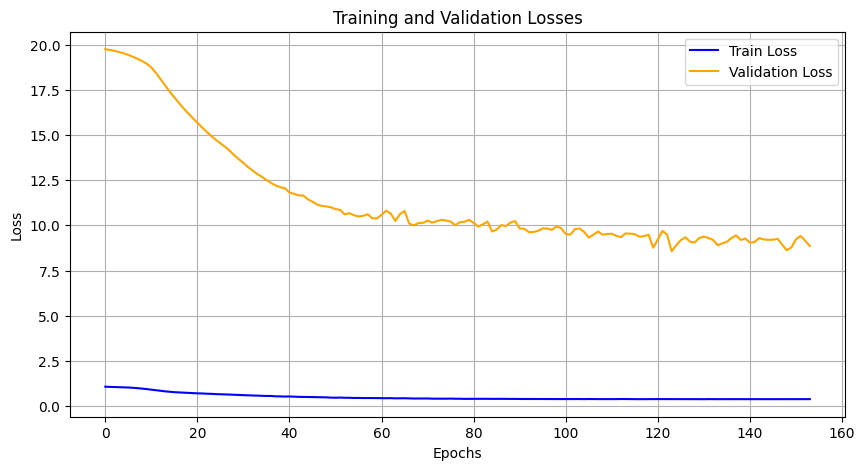

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()